###### Project

In [162]:
import pandas as pd
#import sqlite3
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import datetime as dt
import folium
from folium import plugins
import geopandas
from calendar import monthrange

spray_data = pd.read_csv(
    'Files/spray.csv',  # шлях до файлу, який містить дані
    sep=',',  # роздільник стовпців
    header=0  # номер рядка, що містить заголовок (якщо заголовка немає, можна передати None)
)

train_data = pd.read_csv(
    'Files/train.csv',  # шлях до файлу, який містить дані
    sep=',',  # роздільник стовпців
    
    header=0  # номер рядка, що містить заголовок (якщо заголовка немає, можна передати None)
)

weather_data = pd.read_csv(
    'Files/weather.csv',  # шлях до файлу, який містить дані
    sep=',',  # роздільник стовпців
    header=0  # номер рядка, що містить заголовок (якщо заголовка немає, можна передати None)
)

test_truncated_data = pd.read_excel(
    'Files/test_truncated.xlsx',
    sheet_name='test_truncated',  # прочитати всі листи
    usecols="A:J"
    #nrows=5
)

#train_data
#test_truncated_data.head()
#dates=spray_data [['Date'],['Time']]
#train_data.groupby(train_data["Address"])
#dir(spray_data)
#spray_data.amin(axes='Latitude')
#test_truncated_data.info()
#weather_data
#weather_data

In [163]:
def add_datetime(train_data):
    train_data['day']=pd.to_datetime(train_data.Date).dt.day
    train_data['weekday']=pd.to_datetime(train_data.Date).dt.weekday
    train_data['month']=pd.to_datetime(train_data.Date).dt.month
    train_data['year']=pd.to_datetime(train_data.Date).dt.year
    return train_data

train_data=add_datetime(train_data)
train_data['RESTUANS']=train_data['Species'].str.contains('RESTUANS')
train_data['PIPIENS']=train_data['Species'].str.contains('PIPIENS')

test_truncated_data=add_datetime(test_truncated_data)
weather_data=add_datetime(weather_data)


def bar_chat(_data, grop_list_, agr_colum, agr_func):
    grop_list=[grop_list_]
    agg_func_math = {
        agr_colum: [agr_func]
    }
    plot_mas = _data.groupby(grop_list, group_keys=True, dropna=True).agg(agg_func_math).to_dict()[(agr_colum, agr_func)] 
    fig = plt.figure()
    plt.bar(plot_mas.keys(), plot_mas.values())
    plt.title(f'{grop_list_} {agr_colum} {agr_func} chart')    
    plt.grid(True)   # лінії допоміжної сітки
#bar_chat(test_truncated_data, 'year', 'year', 'count')

def group_data(_data, grop_list_, agr_colum, agr_func):
    grop_list=[grop_list_]
    agg_func_math = {
        agr_colum: [agr_func]
    }
    dict_data=_data.groupby(grop_list, group_keys=True, dropna=True).agg(agg_func_math).to_dict()[(agr_colum, agr_func)]
    df=pd.DataFrame(list(dict_data. items ()), columns = [grop_list_, agr_colum])
    #df.set_index(df[grop_list], *, drop=True, append=False, inplace=False, verify_integrity=False)[source]
    df.set_index(grop_list, inplace=True)
    return df.copy()

def concat_data(train_data):
    Trap=group_data(train_data, 'Trap', 'Latitude', 'min')
    Longitude=group_data(train_data, 'Trap', 'Longitude', 'min')
    NumMosquitos=group_data(train_data, 'Trap', 'NumMosquitos', 'sum')
    WnvPresent=group_data(train_data, 'Trap', 'WnvPresent', 'sum')
    AddressAccuracy=group_data(train_data, 'Trap', 'AddressAccuracy', 'min')
    RESTUANS=group_data(train_data, 'Trap', 'RESTUANS', 'sum')
    PIPIENS=group_data(train_data, 'Trap', 'PIPIENS', 'sum')
    Date_Min=group_data(train_data, 'Trap', 'Date', 'min')
    #Date_Max=group_data(train_data, 'Trap', 'Date', 'max')
    
    frames = [Trap, Longitude, Date_Min, NumMosquitos, WnvPresent, AddressAccuracy, RESTUANS, PIPIENS]
    result = pd.concat(frames, axis=1)
    result.reset_index(inplace=True)
    return result.copy()
#train_data
df=concat_data(train_data[(train_data['year']==2013)])
#df['test']='2021'
df
#weather_data

,Trap,Latitude,Longitude,Date,NumMosquitos,WnvPresent,AddressAccuracy,RESTUANS,PIPIENS
0,T002,41.954690,-87.800991,2013-06-07,1792,8,9,49,34
1,T003,41.964242,-87.757639,2013-06-14,407,7,8,21,19
2,T008,42.008314,-87.777921,2013-06-07,1162,4,9,32,28
3,T009,41.992478,-87.862995,2013-06-07,1085,5,8,34,24
4,T011,41.944869,-87.832763,2013-06-14,171,3,8,23,22
...,...,...,...,...,...,...,...,...,...
69,T233,42.009876,-87.807277,2013-06-07,665,7,9,25,26
70,T235,41.776428,-87.627096,2013-06-07,395,7,8,21,23
71,T236,41.994679,-87.770899,2013-06-07,358,1,8,21,19
72,T900,41.974689,-87.890615,2013-06-07,5689,46,9,185,160


In [164]:
from datetime import datetime, timedelta

def iter_days(draft_year, draft_month):
    dt = datetime(draft_year, draft_month, 1)
    while dt.year == draft_year and  dt.month == draft_month:
        yield dt
        dt += timedelta(days=1)
        
#draft_year_list={2007, 2009, 2013}
#draft_month_list={6, 7, 8, 9}
draft_year_list={2007}
draft_month_list={6}
frames=[]
for draft_year in draft_year_list:
    data_year=train_data[train_data['year']==draft_year].copy()
    #print(draft_year)
    for draft_month in draft_month_list:
        #print(draft_month)
        train_data_month=data_year[(data_year['month']==draft_month)]
        for dt in iter_days(draft_year, draft_month):
            train_data_day=concat_data(train_data_month[(train_data_month['day']==dt.day)])
            if train_data_day.shape[0]>0:
                #Data=np.arrey[train_data_day.shape[0]]=dt
                train_data_day.set_index('Date', inplace=False)
                """train_data_day['Date']=str(dt)
                train_data_day.set_index('Date', inplace=False)
                frames.append(train_data_day)"""
                #print(f'{train_data_day}')
                frames.append(train_data_day)
               
                
                
            #print(train_data_day)
            
        #train_data_day=train_data_month[train_data_month['day']==iter_days]
        #print(train_data_day)
result = pd.concat(frames, axis=0)
result.reset_index()
#result.get_loc(['Trap'])
result

,Trap,Latitude,Longitude,Date,NumMosquitos,WnvPresent,AddressAccuracy,RESTUANS,PIPIENS
0,T002,41.954690,-87.800991,2007-06-05,9,0,9,2,2
1,T009,41.981964,-87.812827,2007-06-05,2,0,8,1,0
2,T011,41.944869,-87.832763,2007-06-05,1,0,8,1,0
3,T015,41.974089,-87.824812,2007-06-05,3,0,8,2,1
4,T016,42.011601,-87.811506,2007-06-05,1,0,8,1,0
...,...,...,...,...,...,...,...,...,...
30,T151,41.916265,-87.800515,2007-06-29,6,0,8,2,1
31,T153,41.907645,-87.760886,2007-06-29,1,0,8,1,0
32,T158,41.682587,-87.707973,2007-06-29,6,0,9,1,0
33,T160,41.903002,-87.688267,2007-06-29,1,0,8,1,1


In [182]:
weather_1=weather_data[weather_data['Station']==1].copy()
weather_1.set_index('Date', inplace=True)
weather_2=weather_data[weather_data['Station']==2].copy()
weather_2.set_index('Date', inplace=True)

weather=weather_1.merge(weather_2,
    #weather_1, left_on='Date', right_on='Date')
    how='inner',
    #on=None, 
    left_on='Date', right_on='Date', 
    #left_index=True, right_index=True,
    #, sort=False,
    suffixes=('_1', '_2'), copy=True
    #, indicator=False, validate=None
)
#weather['Tmax_2']

In [186]:
test_data=result.merge(weather,
    #weather_1, left_on='Date', right_on='Date')
    how='inner',
    #on=None, 
    left_on='Date', right_on='Date', 
    #left_index=True, right_index=True,
    #, sort=False,
    #suffixes=('_x', '_y'), copy=True
    #, indicator=False, validate=None
)


test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 0 to 119
Data columns (total 59 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Trap             120 non-null    object 
 1   Latitude         120 non-null    float64
 2   Longitude        120 non-null    float64
 3   Date             120 non-null    object 
 4   NumMosquitos     120 non-null    int64  
 5   WnvPresent       120 non-null    int64  
 6   AddressAccuracy  120 non-null    int64  
 7   RESTUANS         120 non-null    int64  
 8   PIPIENS          120 non-null    int64  
 9   Station_1        120 non-null    int64  
 10  Tmax_1           120 non-null    int64  
 11  Tmin_1           120 non-null    int64  
 12  Tavg_1           120 non-null    object 
 13  Depart_1         120 non-null    object 
 14  DewPoint_1       120 non-null    int64  
 15  WetBulb_1        120 non-null    object 
 16  Heat_1           120 non-null    object 
 17  Cool_1          

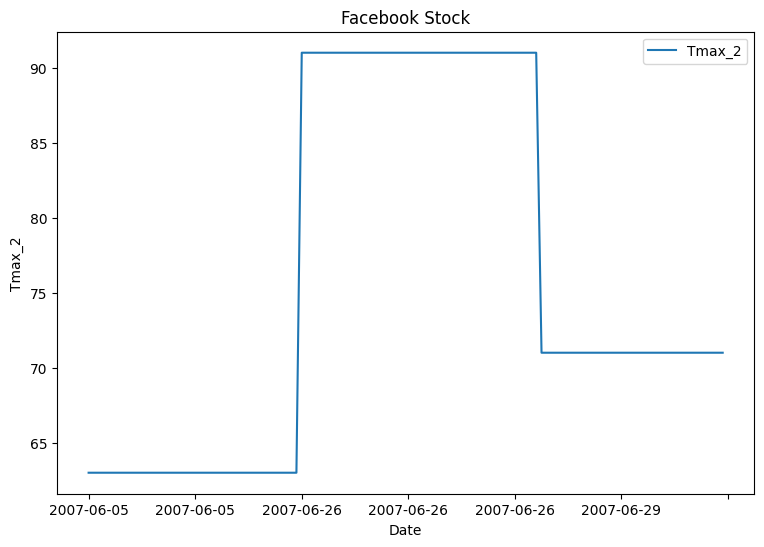

In [205]:
p1=test_data.plot(x='Date', y=['Tmax_2','Water1_2'], figsize=(9,6),
               title='Facebook Stock',xlabel='Date', ylabel='Tmax_2')
#p1.saveing('1.png')

ValueError: x and y must have same first dimension, but have shapes (120,) and (74,)

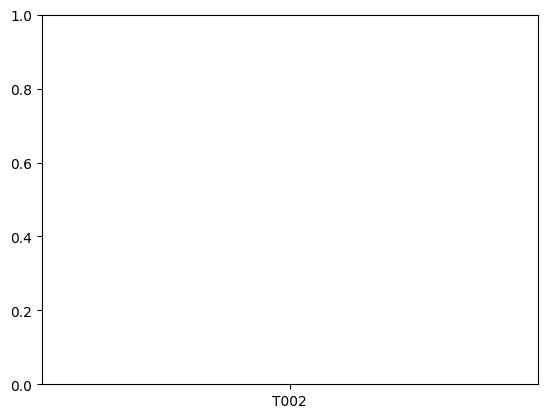

In [188]:
plt.plot(test_data['Trap'], df['NumMosquitos'], color='red', marker='o')
plt.title('NumMosquitos vs Date', fontsize=14)
plt.xlabel('day', fontsize=14)
plt.ylabel('NumMosquitos', fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
def plot_markers(): 
    # train_data_point_map
    draft_year_list={2007, 2009, 2013}
    draft_month_list={6, 7, 8, 9}
    geometry = geopandas.points_from_xy(train_data.Longitude, train_data.Latitude)
    geo_df = geopandas.GeoDataFrame(
        train_data, geometry=geometry
    )
    geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in geo_df.geometry]

    wnvpresentsLayer=folium.FeatureGroup(name='wnvpresents')
    wnvpresentsLayer.add_to(map_)

    # Iterate through list and add a marker for each volcano, color-coded by its type.
    i = 0
    for coordinates in geo_df_list:
        if (geo_df.month[i] == draft_month) and  (geo_df.year[i] == draft_year):
            wnvpresents=int(train_data[(geo_df['Trap'] == geo_df.Trap[i]) & (geo_df['month']==draft_month) 
                       & (geo_df['year']==draft_year)]['WnvPresent'].sum())
            if wnvpresents>0:
                if geo_df.PIPIENS[i] == True:
                    type_color = "green"
                if (geo_df.RESTUANS[i] == True):
                    type_color = "red"
                    # Place the markers with the popup labels and data
                wnvpresentsLayer.add_child(
                    folium.Marker(
                        location=coordinates,
                        popup=geo_df.Trap[i]+ "<br>"
                        +'wnvpresents '+ str(wnvpresents)+ "<br>"+'numMosquitos '+ str(numMosquitos(draft_year, draft_month)),
                        icon=folium.Icon(color="%s" % type_color)
                        )
                )
        i = i + 1

In [ ]:
def plot_datasetes():
    fig = plt.figure()

    plot_mas = test_truncated_data.groupby(['year'], group_keys=True,
                                           dropna=True).agg({'year': ['count']}).to_dict()[('year', 'count')] 
    plt.bar(plot_mas.keys(), plot_mas.values(), color='blue', label='test_truncated_data counts  in year')
    plt.legend()
    plt.grid(True) 



    fig = plt.figure()
    plot_mas = weather_data.groupby(['year'], group_keys=True,
                                           dropna=True).agg({'year': ['count']}).to_dict()[('year', 'count')] 
    plt.bar(plot_mas.keys(), plot_mas.values(), color='pink', label='weather_data counts  in year')
    plt.legend()
    plt.grid(True)   # лінії допоміжної сітки


    fig = plt.figure()
    #fig2 = plt.figure()

    plot_mas = train_data.groupby(['year'], group_keys=True,
                                           dropna=True).agg({'year': ['count']}).to_dict()[('year', 'count')] 
    plt.bar(plot_mas.keys(), plot_mas.values(), color='green', label='train_data counts  in year')
    plt.legend()
    plt.grid(True)   # лінії допоміжної сітки


    fig = plt.figure()
    plot_mas = spray_data.groupby(['year'], group_keys=True,
                                           dropna=True).agg({'year': ['count']}).to_dict()[('year', 'count')] 
    plt.bar(plot_mas.keys(), plot_mas.values(), color='red', label='spray_data counts  in year')
    plt.legend()
    plt.grid(True)   # лінії допоміжної сітки
    
    fig = plt.figure()
    plot_mas = test_truncated_data.groupby(['year'], group_keys=True,
                                           dropna=True).agg({'year': ['count']}).to_dict()[('year', 'count')] 
    plt.bar(plot_mas.keys(), plot_mas.values(), color='red', label='test_truncated_data counts  in year')
    plt.legend()
    plt.grid(True)   # лінії допоміжної сітки

plot_datasetes()

In [ ]:
def bar_chat(_data, grop_list_, agr_colum, agr_func):
    grop_list=[grop_list_]
    agg_func_math = {
        agr_colum: [agr_func]
    }

    plot_mas = _data.groupby(grop_list, group_keys=True, dropna=True).agg(agg_func_math).to_dict()[(agr_colum, agr_func)] 

    fig = plt.figure()
    plt.bar(plot_mas.keys(), plot_mas.values())
    plt.title(f'{grop_list_} {agr_colum} {agr_func} chart')
    
    plt.grid(True)   # лінії допоміжної сітки

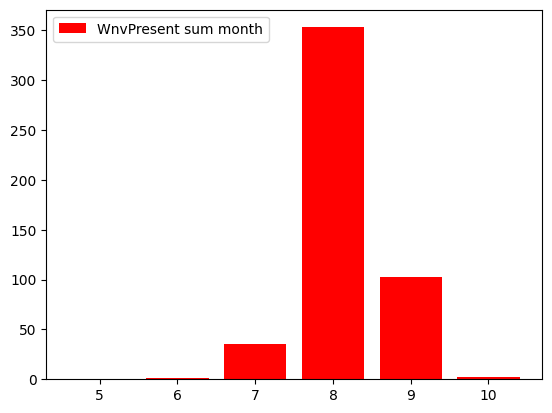

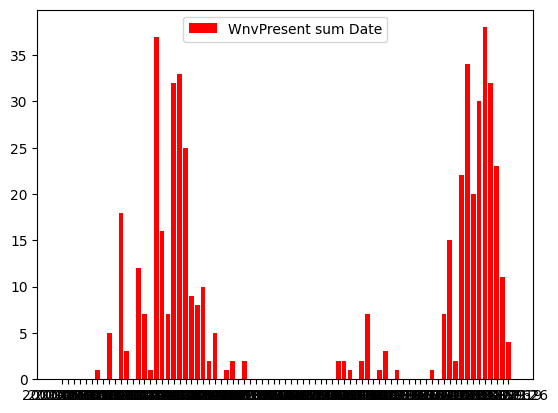

In [184]:
fig = plt.figure()
plot_mas = train_data.groupby(['month'], group_keys=True,
                              dropna=True).agg({'WnvPresent': ['sum']}).to_dict()[('WnvPresent', 'sum')] 
plt.bar(plot_mas.keys(), plot_mas.values(), color='red', label='WnvPresent sum month')
plt.legend()

plt.grid(False)   # лінії допоміжної сітки
#Date
fig = plt.figure()
plot_mas = train_data.groupby(['Date'], group_keys=True,
                              dropna=True).agg({'WnvPresent': ['sum']}).to_dict()[('WnvPresent', 'sum')] 
plt.bar(plot_mas.keys(), plot_mas.values(), color='red', label='WnvPresent sum Date')
plt.legend()

plt.grid(False)   # лінії допоміжної сітки

In [ ]:
train_data_adres.head()

In [ ]:
# Define our key point when map open it
map_ = folium.Map(location=[train_data_adres['Latitude'].mean(),  train_data_adres['Longitude'].mean()],
               tiles="Stamen Terrain", zoom_start=10, control_scale=False)

for la,lo in train_data_adres:
    folium.Marker(
        location=[la,lo],
        icon=folium.Icon(icon_color='white')
    ).add_to(map2)
# Plotting 
map2

In [ ]:
map_ = folium.Map(location=[train_data_adres['Latitude'].mean(),  train_data_adres['Longitude'].mean()],
               tiles="Stamen Terrain", zoom_start=10, control_scale=False)

folium.Marker(train_data_adres['Latitude','Longitude'], popup=train_data_adres['Trap']).add_to(map_)
map_

In [ ]:
#import folium
#Station_1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
#Station_2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

#m = folium.Map(location=[45.5236, -122.6750])
#m = folium.Map(location=[42.391623, -88.089163], tiles="Stamen Terrain", zoom_start=13)


map_ = folium.Map(location=[spray_data['Latitude'].mean(),  spray_data['Longitude'].mean()],
               tiles="Stamen Terrain", zoom_start=10, control_scale=False)

folium.Marker([41.995,  -87.933], popup="CHICAGO O'HARE INTERNATIONAL AIRPORT").add_to(map_)
folium.Marker([41.786,  -88.089163], popup="CHICAGO MIDWAY INTL ARPT").add_to(map_)

folium.CircleMarker(
    location=[spray_data['Latitude'].mean(),  spray_data['Longitude'].mean()],
    radius=10,
    popup="spray_mean",
    color="#3186cc",
    fill=True,
    fill_color="#3186cc",
).add_to(map_)


#train_data_adres
#for index, location_info in train_data.iterrows():
#    folium.Marker([location_info["Latitude"], location_info["Longitude"]], popup=location_info["NumMosquitos"]).add_to(map_)

map_
